# Self Organizing Maps

In [133]:
import numpy as np

# graphics
import matplotlib.pyplot as plt
from IPython.display import display, Image

# contour plots 
import matplotlib.cm as cm

# 3D plots
from mpl_toolkits.mplot3d.axes3d import Axes3D

import sys # system library
sys.path.append('./lib_nn') # my path (linux, Mac OS)

from neural import * # import my library packages

A very important and ingenious application of unsupervised learning are the so-called **Kohonen nets** ([Teuvo Kohonen](https://en.wikipedia.org/wiki/Teuvo_Kohonen), i.e. **self-organizing mappings (SOM)**. Consider a mapping $f$ between a **discrete** $k$-dimensional set (**grid**) of neurons and $n$-dimensional input data $D$ (continuous or discrete), 

$$
f: N \to D.
$$

Since $N$ is descrete, each neuron carrries an index consisting of $k$ natural numbers, denoted as $\bar {i} = (i_1, i_2, ..., i_k)$. Typically, the dimensions satisfy $n \ge k$. When $n > k$, one talks about **reduction of dimensionality**, as the input space $D$ has more dimensions than the grid of neurons. 

Two examples of such networks are visualized in {numref]`koh-fig`. The left panel shows a 2-dim. input space $D$, and a one dimensional grid on neurons. The input point $(x_1,x_2)$ enters all the neuron of the grid, and one of them (with best-suited weights) becomes the winner (red dot). The gray oval indicates the neighborhood of the winner. The right panel shows an analogous situation for the case of a 3-dim. input and 2-dim. grid of neurons. Here, for clarity, we only indicated the edges entering the winner, but they also enter all the other neurons, as in the left panel. 

:::{figure-md} koh-fig

<img src="images/koha.png" width="500px">

Example of Kohonen networks. Left: 1-dim. grid of neurons $N$ and 2-dim. input space $D$. Right: 2-dim. grid of neurons $N$ and 3-dim. input space $D$. The red dot indicates the winner, and the gray oval marks its neighborhood.
:::

One defines the neuron **proximity function**, $\phi (\bar {i}, \bar {j})$, which assigns, to a pair of neurons, a real number depending on their relative position in the grid. This function must decrease with the distance between the neuron indices. A popular choice is a Gaussian,

$$ \phi(\bar{i}, \bar{j})=\exp\left [ -\frac{(i_1-j_1)^2+...+(i_k-j_k)^2}{2 \delta^2} \right ] ,$$

where $\delta$ is the **neighborhood radius**. For a 1-dim. grid it becomes $ \phi(i,j)=\exp\left [ -\frac{(i-j)^2}{2 \delta^2} \right ]$.

## Kohonen's algorithm

The set up of Kohonen's algorithm is similar to the unsupervised learning discussed in the previous chapter. Each neuron $\bar{i}$ obtains weights $f\left(\bar{i}\right)$, which are elements of $D$, i.e. form $n$-dimensional vectors. One may simply think of this as placing the neurons in some locations in $D$. When an input point $P$ form $D$ is fed into the network, one looks for a closest neuron, which becomes the **winner**, exactly as in the algorithm from section {ref}`inn-sec`. However, here comes an important difference: Not only the winner is attracted (updated) a bit towards $P$, but also its neighbors, to a lesser and lesser extent the farther they are from the winner.

```{admonition} Winner-take-most strategy
:class: important

Kohonen's algorithm involves the "winner take most" strategy, where not only the winner neuron is updated (as in the winner-take-all case), but also its neighbors. The neighbors update is strongest for the nearest neighbors, and gradually weakens with the distance from the winner.  
```

```{admonition} Kohnen's algorithm
:class: important

0. Initialize (for instance randomly) $n$-dimensional weights $w_i$, $i-1,\dots,m$ for all the $m$ neurons in the grid. Set an initial neighborhood radius $ \delta $ and an initial learning speed $ \varepsilon $.

1. Choose (randomly) a data point $P$ wigh coordinates $x$ from the input space (possibly with an appropriate probability distribution).

2. Find the $ \bar {l} $ neuron (the winner) for which the distance from $P$ is the smallest.

3. The weights of the winner and its neighbors are updated according to the **winner-take-most** recipe:

$$w_{\bar{i}} \to w_{\bar{i}} + \varepsilon \phi(\bar{i}, \bar{l})(x - w_{\bar{i}}), \hspace{1cm} i=1, . . . , m. 
$$

4. Loop from $1.$ for a specified number of points. 

5. Repeat from $1.$ in rounds, until a satisfactory result is obtained or the maximum number of rounds is reached. In each round  **reduce** $ \varepsilon $ and $ \delta $ according to a chosen policy. 
```

The way the reduction of $ \varepsilon $ and $ \delta $ is done is very important for the desired outcome of the algorithm (see exercises). 


###  2-dim. data and 1-dim. neuron grid

Let us see how the procedure works on a simple example. We map a grid of **num** neurons into (our favorite!) circle. So we have here the reduction of dimensions: $n=2$, $k=1$. 

In [2]:
num=100 # number of neurons

The proximity function

In [3]:
def phi(i,k,d):                       # proximity function
    return np.exp(-(i-k)**2/(2*d**2)) # Gaussian

looks as follows around $k=50$ and for the width parameter $\delta=5$:

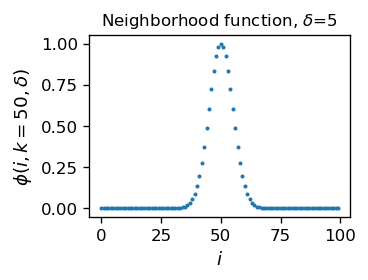

In [4]:
k=50
d=5

plt.figure(figsize=(2.8,2),dpi=120)
plt.title("Neighborhood function, $\delta$="+str(d),fontsize=10) 

ind=[i for i in range(num)]
ph= [phi(i,k,d) for i in range(num)]

plt.scatter(ind,ph,s=2)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$\phi(i,k=$'+str(k)+'$,\delta)$',fontsize=11);    

As a feature of the Gaussian, at $|k-i|=\delta$ it drops to $~60\%$ of the central value, and at $|k-i|=3\delta$ to $~1\%$, a tiny fraction. Hence $\delta$ controls the size of the neighborhood of the winner. The neuron farther away from the winner than $3\delta$ are practically left unupdated. 

We initiate the network by by placing the grid on the plane (on the square $[0,1]\times [0,1]$), with a random location of each neuron. The line is drawn to guide the eye along the neuron indices: $1,2,3,\dots m$,  which are chaotically distributed.

In [5]:
W=np.array([func.point_c() for _ in range(num)]) # random initialization of weights

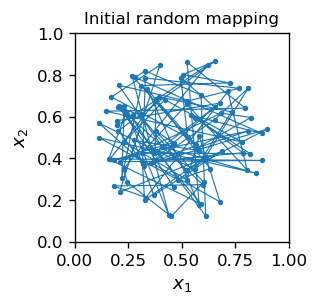

In [6]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Initial random mapping",fontsize=10) 
plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(W[:,0],W[:,1],s=5)
plt.plot(W[:,0],W[:,1],linewidth=0.7)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    

The line connects the subsequent neurons ... They are chaotically scattered around the region.

In [7]:
eps=.5   # initial learning speed 
de = 10  # initial neighborhood distance
ste=0    # inital number of caried out steps

In [8]:
# Kohonen's algorithm
for _ in range(150): # rounds
    eps=eps*.98      # dicrease learning speed
    de=de*.95        # ... and the neighborhood distance
    for _ in range(100):        # loop over points
        p=func.point_c()        # random point
        ste=ste+1               # steps
        dist=[func.eucl(p,W[k]) for k in range(num)] 
         # array of squares of Euclidean disances between p and the neuron locations
        ind_min = np.argmin(dist) # index of the winner
        for k in range(num):      # for all the neurons
            W[k]+=eps*phi(ind_min,k,de)*(p-W[k]) 
             # update of the neuron locations (weights), depending on proximity

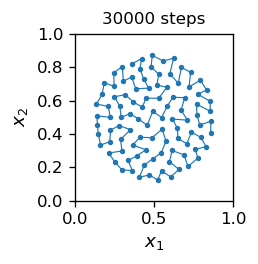

In [423]:
fk=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title(str(ste)+" steps",fontsize=10) 
plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(W[:,0],W[:,1],s=5)
plt.plot(W[:,0],W[:,1],linewidth=0.7)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.tight_layout();    

In [10]:
# fk.savefig('images/ka200000.png');

As the algorith progresses (see {numref}`kohstory-fig`) the neuron grid first "straightens up", and then gradually fills the whole space $D$ (circle) in such a way that the neurons with adjacent indices are located close to each other. 
Figuratively speaking, a new point $x$ attracts towerds itself the nearest neuron (the winner), and to a weaker extent its neighbors. At the beginning of the algorithm the neighborhood distance **de** is large, so large chunks of the nighboring point in input grid are pulled together, and the arrangement looks as the top right corner of {numref}`kohstory-fig`. At later stages **de** is smaller, so only the winner and possibly its immediate neighbors are attracted to a new point. 
After completion, individual neurons "specialize" (are close to) in a certain data area. 

In the present example, after about 20000 steps the result practically stops to change. 

:::{figure-md} kohstory-fig

<img src="images/kaall.png" width="800px">


Progress of Kohonen's algorithm. The lines, drawn to guide the eye, connects neurons with adjacent indices.
:::

```{admonition} Kohonen network as a classifier
:class: note

Having the trained network, we may use it as classifier similarly as in chapter {\ref}`un-lab`. We label a point from $D$ with the index of the nearest neuron.
```

The plots in {numref}`kohstory-fig` are plotted in coordinates $(x_1,x_2)$, that is, from the "point of view" of the $D$-space. One may also look at the result from the point of view of the $N$-space, i.e. plot $x_1$ and $x_2$ as functions of the neuron index $i$: 

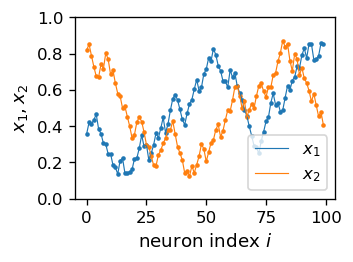

In [11]:
tn = [i for i in range(num)]

plt.figure(figsize=(2.8,2),dpi=120)
#plt.title("Kohonen network",fontsize=11) 
#plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(tn,W[:,0],s=3)
plt.plot(tn,W[:,0],linewidth=0.7)

plt.scatter(tn,W[:,1],s=3)
plt.plot(tn,W[:,1],linewidth=0.7)

plt.xlabel('neuron index $i$',fontsize=11)
plt.ylabel('$x_1,x_2$',fontsize=11)

plt.legend(('$x_1$','$x_2$'),fontsize=10);    

We note that the jumps in the above plotted curves are small. This can be seen quntitatively in the histogram below, where the average distance is about 0.07.

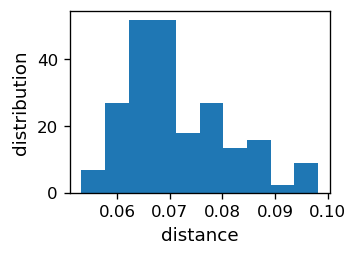

In [12]:
dd=[np.sqrt((W[i+1,0]-W[i,0])**2+(W[i+1,1]-W[i,1])**2) for i in range(num-1)]
        # array of distances between subsequent neurons in the grid

plt.figure(figsize=(2.8,2),dpi=120)

plt.xlabel('distance',fontsize=11)
plt.ylabel('distribution',fontsize=11)

plt.hist(dd, bins=10, density=True);   # histogram

```{admonition} Remarks
:class: note 

- We took a situation in which the data space with the dimension $n = 2$ is "sampled" by a discrete set of neurons forming  $k=1$-dimensional grid. Hence we have dimensional reduction.

- The outcome of the algorithm is a network in which a given neuron "focuses" on data from its vicinity. In a general case where the data are non-uniformly distributed, the neurons would fill the area containing more data more densely.

- The fact that there are no line intersections is a manifestation of topological features, discussed in detail below. 

- The policy of choosing initial $\delta$ and $\varepsilon $ parameters and reducing them appropriately in subsequent rounds is based on experience and non-trivial.

- The final result is not unequivocal, i.e. running the algorithm with a different initialization of the weights (positions of neurons) yields a different outcome, equally "good".

- Finally, the progress and result of the algorithm is reminiscent of the construction of the [Peano curve](https://en.wikipedia.org/wiki/Peano_curve) in mathematics, which fills an area with a line.
```

### 2 dim. color map

Now we come a case of 3-dim. data and 2-dim. neuron grid, which is a situation from the right panel of {numref}`koh-fig`. An RGB color is described with three numbers from $[0,1]$, so it can nicely serve as input in our example.

The distance squared between two colors (this is just a distance between two points in the 3-dim. space) is taken in the Euclidean form 

In [13]:
def dist3(p1,p2): 
    """
    Square of the Euclidean distance between points p1 and p2
    in 3 dimensions.
    """
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2

In [14]:
def phi2(ix,iy,kx,ky,d):  # proximity function for 2-dim. grid
    return np.exp(-((ix-kx)**2+(iy-ky)**2)/(d**2))  # Gaussian

In [84]:
def rgbn():
    r,g,b=np.random.random(),np.random.random(),np.random.random()
    norm=np.sqrt(r*r+g*g+b*b)
    return np.array([r,g,b]/norm)

In [85]:
rgbn()

array([0.1234176 , 0.55504897, 0.82261093])

Next, we generate a sample of **ns** points with RGB colors:

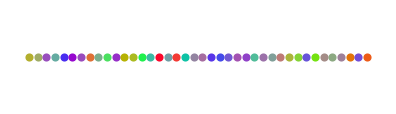

In [94]:
ns=40  # number of colors in the sample

samp=[rgbn() for _ in range(ns)]
       # random sample

pls=plt.figure(figsize=(4,1),dpi=120)
plt.axis('off')
for i in range(ns): plt.scatter(i,0,color=samp[i], s=15); 

We use **size** x **size** grid of neurons. Each neuron's position (color, or weight) in the 3-dim. space is initialized randomly:

In [119]:
size=40  # neuron array of size x size (40 x 40)

tab=np.zeros((size,size,3)) 

for i in range(size):          # i index in the grid    
    for j in range(size):      # j index in the grid
        for k in range(3):     # RGB: 0-red, 1-green, 2-blue
            tab[i,j,k]=np.random.random() # random number form [0,1]
            # 3 RGB components for neuron in the grid positin (i,j)

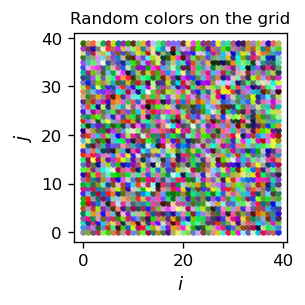

In [120]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Random colors on the grid",fontsize=10) 

for i in range(size):
    for j in range(size):
        plt.scatter(i,j,color=tab[i][j], s=8) 
plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

Now we are ready to run Kohonen's algorithm:

In [121]:
eps=.5   # initial parameters
de = 20   

In [122]:
for _ in range(150):    # rounds
    eps=eps*.995      
    de=de*.96           # de shrinks faster than eps     
    for s in range(ns): # loop over the points in the data sample       
        p=samp[s]       # point from the sample
#        p=[np.random.random() for _ in range(3)]
        dist=[[dist3(p,tab[i][j]) for j in range(size)] for i in range(size)] 
                        # distance to all neurons
        ind_min = np.argmin(dist) # the winner index
        ind_x=ind_min//size       # a trick to get a 2-dim index
        ind_y=ind_min%size

        for j in range(size): 
            for i in range(size):
                tab[i][j]+=eps*phi2(ind_x,ind_y,i,j,de)*(p-tab[i][j]) # update         

As a result we get an arrangement of our color sample in two dimensions in such a way that the neighboring areas have a similar color:

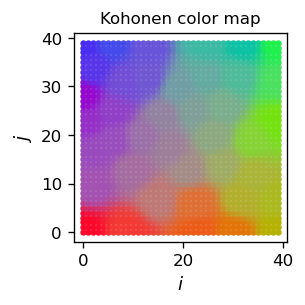

In [123]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Kohonen color map",fontsize=10) 

for i in range(size):
    for j in range(size):
        plt.scatter(i,j,color=tab[i][j], s=8)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

```{admonition} Remarks
:class: note

- The areas for the individual colors of the sample have a comparable area. Generally, the area is proportional to the sample size.

- To get sharper boundaries between regions, de has to shrink faster than eps. Then, in the final stage of learning, the neuron update process takes place with small neighborhood radius.
```

## U-matrix

A convenient way to present the results of the Kohonen algorithm when the grid is 2-dimensional is via the **unified distance matrix** (shortly **U-matrix**). The idea is to plot a 2-dimensional grayscale map with the intensity given by the averaged distance (in $D$-space) of the neuron to its immediate neighbors, and not the neuron poperty itself (such as the color in the plot above). This is particularly useful when the dimension of the input space is large, when it is difficult to visualize the results directly.

The definition of a U-matrix element $U_{ij}$ is shown in {numref}`udm-fig`. Let $d$ be the distance in $D$-space and $[i,j]$ denote the neuron of indices $i,j$ . We take

$$
U_{ij}=\sqrt{d\left([i,j],[i+1,j]\right)^2+d\left([i,j],[i-1,j]\right)^2+
        d\left([i,j],[i,j+1]\right)^2+d\left([i,j],[i,j-1]\right)^2 }
$$

:::{figure-md} udm-fig

<img src="images/udm.png" width="150px">

Construction of $U_{ij}$: geometric average of the distance along the indicated links.
:::

In [126]:
udm=np.zeros((size-2,size-2)) # create U-matrix with elements = 0

for i in range(1,size-1):
    for j in range(1,size-1):
        udm[i-1][j-1]=np.sqrt(dist3(tab[i][j],tab[i][j+1])+dist3(tab[i][j],tab[i][j-1])+
                            dist3(tab[i][j],tab[i+1][j])+dist3(tab[i][j],tab[i-1][j]))
                     # U-matrix as explained above

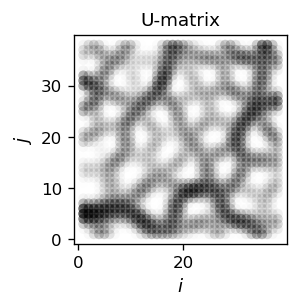

In [134]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("U-matrix",fontsize=11) 

for i in range(size-2): # loops over indices exclude the first and last point of the grid
    for j in range(size-2):
        plt.scatter(i+1,j+1,color=[0,0,0,2*udm[i][j]], s=10) 
            # color format: [R,G,B,intensity], 2 just scales up
plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

The white regions in the above figure correspond to clusters, separated with the darker regions. The higher is the boundary between clusters, the darker the plot.
The same may be visualized in a 3D figure:

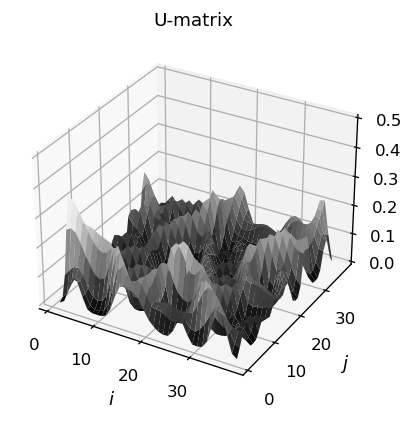

In [135]:
fig = plt.figure(figsize=(4,4),dpi=120)
axes1 = fig.add_subplot(111, projection="3d")
ax = fig.gca(projection='3d')

xx_1 = np.arange(1, size-1, 1)
xx_2 = np.arange(1, size-1, 1)

x_1, x_2 = np.meshgrid(xx_1, xx_2)

Z=np.array([[udm[i][j] for i in range(size-2)] for j in range(size-2)])

ax.set_zlim(0,.5)

ax.plot_surface(x_1,x_2, Z, cmap=cm.gray)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

plt.title("U-matrix",fontsize=11);


We an now classify a given (new) data point according to the obtained map.

In [136]:
nd=[np.random.random(),np.random.random(),np.random.random()]

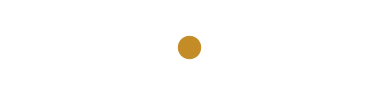

In [143]:
plt.figure(figsize=(6.5,1.5))

plt.axis('off')
plt.scatter(0,0,color=nd, s=500); 

It is useful to obtain a distance map from from this point:

In [144]:
tad=np.zeros((size,size))

for i in range(size):
    for j in range(size):
        tad[i][j]=dist3(nd,tab[i][j])
        

ind_m = np.argmin(tad) # winner
in_x=ind_m//size      
in_y=ind_m%size 

da=np.sqrt(tad[in_x][in_y])

print("Closest neuron grid coordinates: (",in_x,",",in_y,")")
print("Distance: ",np.round(da,3))

Closest neuron grid coordinates: ( 28 , 5 )
Distance:  0.032


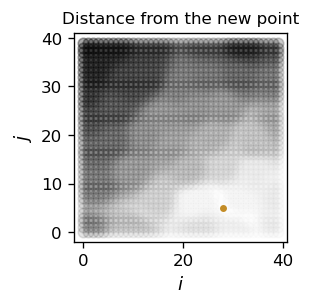

In [139]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Distance from the new point",fontsize=10) 

for i in range(size):
    for j in range(size):
        plt.scatter(i,j,color=[0,0,0,tad[i][j]/3], s=40) 
        
plt.scatter(in_x,in_y,color=nd, s=10) 

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

The lightest region indicates the cluster, to which the point belongs. The darker the region, the lager the distance to the corresponding neurons. 

### Mapping colors on a line

In this subsection we present an example of reduction of 3-dim. data in a 1-dim. neuron grid. This proceeds along the lines of the previous evaluation, so we are brief in comments.

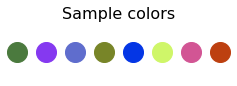

In [160]:
ns=8

samp=[[np.random.random(),np.random.random(),np.random.random()] for _ in range(ns)]

plt.figure(figsize=(4,1))
plt.title("Sample colors",fontsize=16) 

plt.axis('off')

for i in range(ns):
    plt.scatter(i,0,color=samp[i], s=400);

In [ ]:
si=50  # 1D grid of si neurons

tab2=np.zeros((si,3))

for i in range(si):      
    for k in range(3):                # RGB components
        tab2[i][k]=np.random.random() # random initialization

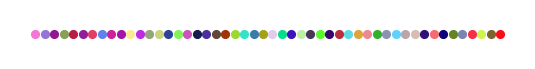

In [161]:
plt.figure(figsize=(5.5,0.5),dpi=120)
plt.axis('off')

for i in range(si):
    plt.scatter(i,0,color=tab2[i], s=20); 

In [162]:
eps=.5    
de = 20   

In [165]:
for _ in range(200): 
    eps=eps*.99      
    de=de*.96        
    for s in range(ns):       
        p=samp[s]
        dist=[dist3(p,tab2[i]) for i in range(si)] 
        ind_min = np.argmin(dist)          
        for i in range(si):
            tab2[i]+=eps*phi(ind_min,i,de)*(p-tab2[i]) 

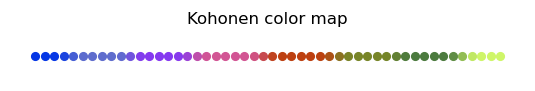

In [170]:
plt.figure(figsize=(5.5,.5),dpi=120)
plt.title("Kohonen color map",fontsize=10) 
plt.axis('off')

for i in range(si):
    plt.scatter(i,0,color=tab2[i], s=20); 

We note smooth transitions between colors. The formation of clusters can be seen with $U$-matrix, which now is of course one-dimensional:

In [ ]:
ta2=np.zeros(si-2)

for i in range(1,si-1):
    ta2[i-1]=np.sqrt(dist3(tab2[i],tab2[i+1])+dist3(tab2[i],tab2[i-1]))

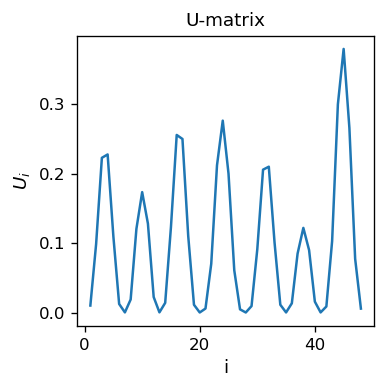

In [168]:
        
plt.figure(figsize=(3.2,3.2),dpi=120)
plt.title("U-matrix",fontsize=11) 

xr=np.array([i for i in range(1,si-1)])

plt.plot(xr,ta2) 

plt.xlabel('i',fontsize=11)
plt.ylabel('$U_i$',fontsize=11);

The minima (there are 8 of them, which is the multiplicity of the sample) indicate the clusters. The height of the separating peaks shows how much the colors differ.

### Wikipedia articles' similarity

The input space may have very large dimensions. In the [Wikipedia example](https://en.wikipedia.org/wiki/Self-organizing_map) below, one takes articles from various fields and computes frequencies of words (for instance, how  many times the word "goalkeeper" has been used, divided by the total number of words in the article). So essentially the dimensionality is of the oder of the number of English words, a huge number $\sim 10^5$! Then one uses Kohonen's algorith to carry out reduction into a 2-dim. grid of neurons. The U-matrix is following:

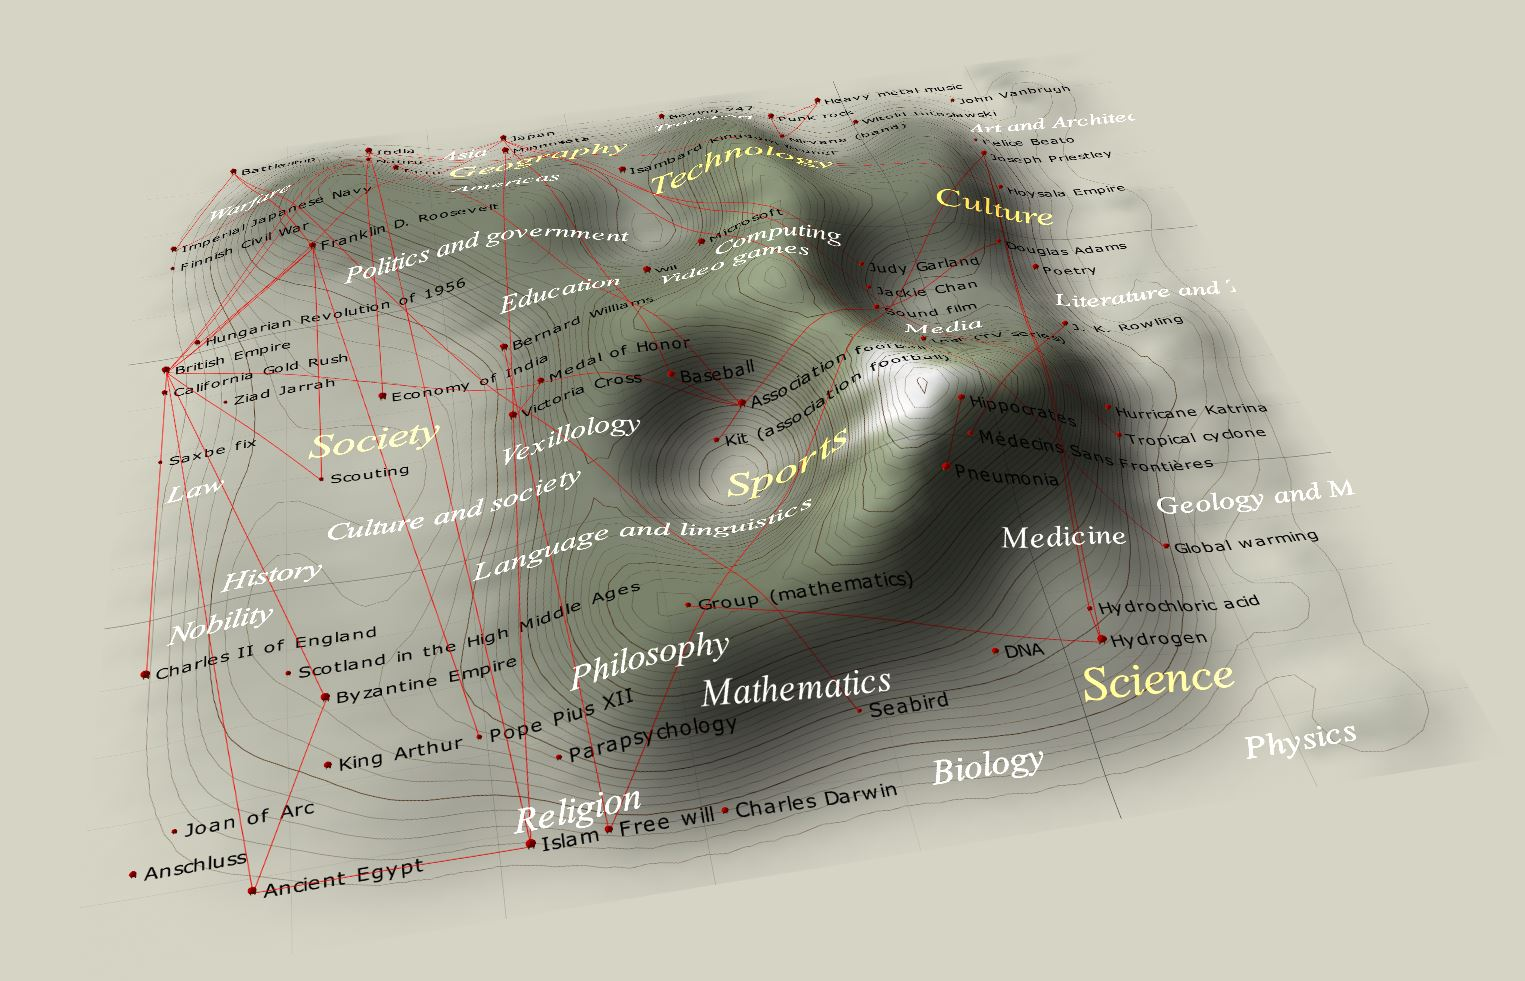

In [169]:
Image(filename="images/Self_oraganizing_map_cartography.jpg",width=720)

In particular we note that articles on sports are special and form a well-defined cluster. This is not surprising, as the jargon is very specific.

## Mapping 2-dim. data into a 2-dim. grid 

Finally, we come to a very important case of mapping 2-dim. data on a 2-dim. grid, as this is realized in our vision system between the retina and the visual cortex. 

The algorithm proceedes analogously to the previous cases. We initialize an $n \times n$ grid of neurons, placing them randomly in the square $[0,1]\times [0,1]$.

In [327]:
n=10
sam=np.array([func.point() for _ in range(n*n)])

The lines, drawn to guide the eye, join the adjacent index pairs [i,j] and [i+1,j], or [i,j] and [i,j+1]. The neurons in the interior of the grid have 4 nearest neighbors, those at the boundary 3, except for the corners, which have 2.

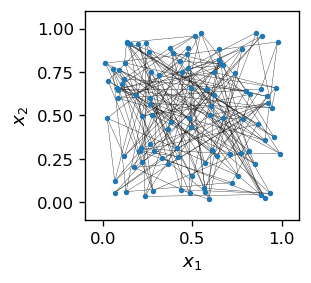

In [328]:
plt.figure(figsize=(2.3,2.3),dpi=120)

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
 
plt.scatter(sam[:,0],sam[:,1],s=5,zorder=3)

# draw the lines
for j in range(n):        # rows
    for i in range(n-1):  # columns
        plt.plot([sam[i+n*j,0],sam[i+1+n*j,0]],[sam[i+n*j,1],sam[i+1+n*j,1]],
                 linewidth=.2,c='black')

for j in range(n-1):       # rows
    for i in range(n):     # columns
        plt.plot([sam[i+n*j,0],sam[i+n*(j+1),0]],[sam[i+n*j,1],sam[i+n*(j+1),1]],
                 linewidth=.2,c='black')
         
plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);    

We note a total initial "chaos", as the neurons are located randomly. Now comes Kohonen's miracle:   

In [329]:
eps=.5   # initial learning speed
de = 3   # initial neighborhood distance
nr = 100 # number of rounds
rep= 300 # number of points in each round
ste=0    # inital number of caried out steps

In [380]:
# analogous to the previous codes
for _ in range(10):   # rounds
    eps=eps*.97      
    de=de*.98         
    for _ in range(rep):    # repeat for rep points
        ste=ste+1
        p=point() 
        dist=[func.eucl(p,sam[l]) for l in range(n*n)] 
        ind_min = np.argmin(dist) 
        ind_i=ind_min%n
        ind_j=ind_min//n       
        
        for j in range(n): 
            for i in range(n):
                sam[i+n*j]+=eps*phi2(ind_i,ind_j,i,j,de)*(p-sam[i+n*j]) 


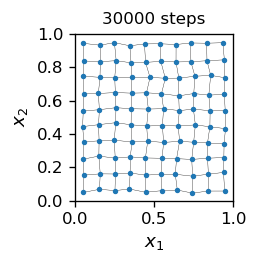

In [381]:
fl=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title(str(ste)+" steps",fontsize=10) 

plt.xlim(0,1)
plt.ylim(0,1)
 
plt.scatter(sam[:,0],sam[:,1],s=5,zorder=3)

for j in range(n):       # rows
    for i in range(n-1): # columns
        plt.plot([sam[i+n*j,0],sam[i+1+n*j,0]],[sam[i+n*j,1],sam[i+1+n*j,1]],
                 linewidth=.2,c='black')

for j in range(n-1):       # rows
    for i in range(n): # columns
        plt.plot([sam[i+n*j,0],sam[i+n*(j+1),0]],[sam[i+n*j,1],sam[i+n*(j+1),1]],
                 linewidth=.2,c='black')
        
        
plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)

plt.tight_layout();    

In [382]:
# fl.savefig('images/kb30000.png')

:::{figure-md} kohstory2-fig

<img src="images/kball.png" width="800px">


Progress of Kohonen's algorithm. The lines, drawn to guide the eye, connects neurons with adjacent indices.
:::

As the algorithm progresses, chaos changes into nearly perfect order, with the grid placed unifomly in the square of the data, with only slight displacements from a regular arrangement. On the way, at 600 steps, we notice a phenomenon called "twist", where many neurons have a close location an the grid is crumpled.

## Topological properties

Recall the Voronoi construction of categories introduced in section {ref}`vor_lab`. One can simply use it now, treating the neurons from a grid as the Voronoi points. The Voronoi construction provides a mapping $v$ from the data space $D$ to the neuron space $N$,

$$ 
v: D \to N 
$$

(note that this goes in the opposite direction than function $f$ defined at the beginning of this chapter). 

For instance, we take the bottom right panel of {numref}`kohstory2-fig`, construct the Voronoi areas for all the neurons, and thus obtain a mapping for all poins in the $(x_1,x_2)$ square. The reader may notice that there is an ambiguity for points lying exactly at boundaries between areas, but this can be taken care of by using an additional prescription, for instance, selecting a neuron lying at direction which has the lowest angle, etc. 

Now a key observation: 

```{admonition} Topological property
:class: important

For situations such as in the bottom right panel of {numref}`kohstory2-fig`, mapping $v$ has the property that when $d_1$ and $d_2$ from $D$ are close to each other, then also their corresponding neurons are close, i.e. the indices $v(d_1)$ and $v(d_2)$ are close. 
```

This observation is obvious. Since $d_1$ and $d_2$ are close (and we mean very close, closer than the resolution of the grid), then they must belong either to

   - the same Voronoi area, where $v(d_1)=v(d_2)$, or
   - neighboring Voronoi areas. 
   
Since for the considered situation the neighboring areas have the grid indices differing by 1, the conclusion that $v(d_1)$ and $v(d_2)$ are close follows.

Note that this feature of Hohonen's maps is far from trivial and does not hold for a general mapping. Imagine for instance that we stop our simulations for {numref}`kohstory2-fig` after 40 steps (top central panel) and are left with a "twisted" grid. In the vicinity of the twist, the indices of the adjacent Voronoi areas differ largely, and the considered topological property no longer holds. 

The discussed topological propery has general and far-reaching consequences. First, it allows to carry over "shapes" from $D$ to $N$. Imagine that we have a circle in the $D$-space:

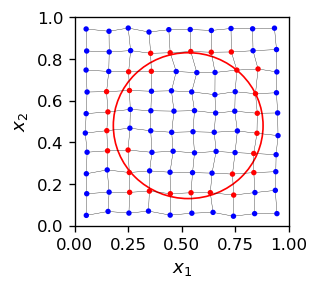

In [417]:
plt.figure(figsize=(2.3,2.3),dpi=120)

plt.xlim(0,1)
plt.ylim(0,1)

co=['blue' for _ in range(n*n)]
ci=np.array(
  [13,14,15,16,21,22,23,26,27,31,37,38,41,48,51,58,61,68,71,72,77,78,82,83,84,85,86,87])

for i in ci: co[i]='red'

plt.scatter(sam[:,0],sam[:,1],c=co,s=5,zorder=3)

for j in range(n):       # rows
    for i in range(n-1): # columns
        plt.plot([sam[i+n*j,0],sam[i+1+n*j,0]],[sam[i+n*j,1],sam[i+1+n*j,1]],
                 linewidth=.2,c='black')

for j in range(n-1):       # rows
    for i in range(n): # columns
        plt.plot([sam[i+n*j,0],sam[i+n*(j+1),0]],[sam[i+n*j,1],sam[i+n*(j+1),1]],
                 linewidth=.2,c='black')
        
circ=plt.Circle((0.53,0.48), radius=.35, color='red', fill=False)
plt.gca().add_artist(circ)

        
plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11);

where the red points indicate the winners for certain sections of the circle. When we draw these points alone in the $N$ space, we get

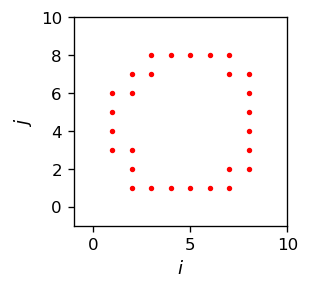

In [422]:
plt.figure(figsize=(2.3,2.3),dpi=120)

plt.xlim(-1,10)
plt.ylim(-1,10)

plt.scatter(ci//10,ci%10,c='red',s=5)

        
plt.xlabel('$i$',fontsize=11)
plt.ylabel('$j$',fontsize=11);

This looks as a (rough and discrete) circle. Note that in our example we only have $n^2=100$ pixels to our disposal, and the image would look better and better with increasing $n$. At some point one would reach the 10M pixels resolution of typical camera, and then the image would look smooth. 

```{admonition} Vision
:class: important

The topological property of the Kohonen mapping is believed to have a prime importance in our vision system and the perception of objects. ...

```

Another key topological feature is the preservation of connectedness. If an area $A$ in $D$ is connected (is in one piece), then its image $v(A)$ in $N$ is also connected (we ignore the desired rigor here as to what "connected" means in a discrete space and rely on intuition). So things do not get "warped up" when transforming form $D$ to $N$.


Note that the discussed topological features need not be present when dimensionality is reduced, as in our previous examples. Take for instance the bottom right panel of {numref}`kohstory-fig`. There, many neighboring pairs of Voronoi areas correspond to distant indices, and it is no longer true that $v(d_1)$ and $v(d_2)$ are close for close $d_1$ and $d_2$, as these points may belong to different Voronoi areas with distant indices. 

Our example with the circle now looks like this:

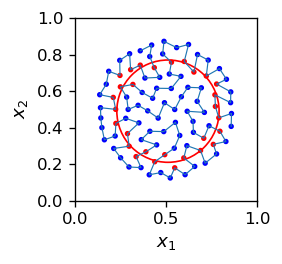

In [476]:
plt.figure(figsize=(2.5,2.3),dpi=120)
plt.xlim(0,1)
plt.ylim(0,1)
 

co=['blue' for _ in range(num)]
ci=np.array(
  [3,6,7,10,14,15,21,24,25,30,31,39,40,44,47,49,52,54,56,72,73,80,85,86,89,92,95,96,97])

for i in ci: co[i]='red'

    
plt.scatter(W[:,0],W[:,1],c=co,s=5)
plt.plot(W[:,0],W[:,1],linewidth=0.7)

        
circ=plt.Circle((0.51,0.49), radius=.28, color='red', fill=False)
plt.gca().add_artist(circ)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.tight_layout();    

When we go along the grid indices, we see the image of our circle (red dots) as a bunch of **disconnected** sections. Topology is not preserved.

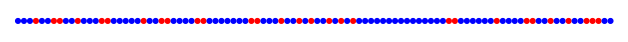

In [474]:
plt.figure(figsize=(6.5,0.2),dpi=120)

plt.xlim(-1,100)
plt.ylim(-1,1)

tl=[i for i in range(num)]

plt.scatter([i for i in range(num)],[0 for i in range(num)],c=co,s=7)

plt.axis('off')       
plt.xlabel('$i$',fontsize=11);

```{note}
Topological features of Kohonen's maps hold for equal dimensionalities of the input space and the neuron grid, $n=k$, and in general do not hold for the reduced dimensionality case, $k<n$.
```

## Lateral inhibition

In a last topic of these lectures, we return to the issue of how the competition for the "winner" is realized. Abobve, we habe just used the minimum (or maximum) functions, but ... external wizard, control unit - not there!

Neurons in the same laye do talk to one another, and this allows for an arrangement of competition and a natural realization of the strategy winner-take-most

:::{figure-md} lat-fig

<img src="images/lat2.png" width="170px">

Network with inter-neuron coupling used for modeling lateral inhibition.
:::

$$ 
y_i = s_i + \sum_{j\neq i} F_{ij} y_j.
$$

$$
\sum_j (\delta_{ij}-F_{ij}) y_j = s_i , ~~~s_i = x w_i, ~~~ F_{ii}=0.
$$

$$ (I-F) y = s $$

$$ y= (I-F)^{-1} s $$


Coupling (damping) matrix:

We will take, for example

$ F_ {ii} = $ 0,

$ F_ {ij} = - a \exp (- | i-j | / b) ~~ $ for $ i \neq j $, $ ~~ a, b> 0 $,

i.e. attenuation is strongest for close neighbors and it decreases with distance with a characteristic scale $b$.

In [41]:
ns = 30;       # number of neurons
b = 4;         # parameter controling the decrease of damping with distance
a = 1;         # magnitude of damping
eps = .1;      # coupling parameter

F=np.array([[-a*np.exp(-np.abs(i-j)/b) for i in range(ns)] for j in range(ns)]) 
                    # exponential fall-off
    
for i in range(ns):
    F[i][i]=0       # no self-damping
    

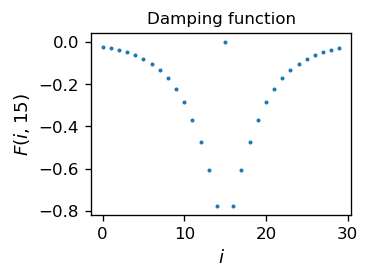

In [42]:
plt.figure(figsize=(2.8,2),dpi=120)
plt.title("Damping function",fontsize=10) 

ii=[i for i in range(ns)]
ff= [F[i][15] for i in range(ns)]

plt.scatter(ii,ff,s=2)

plt.xlabel('$i$',fontsize=11)
plt.ylabel('$F(i,15)$',fontsize=11);    

In [43]:
s = np.array([2**2/((i - ns/2)**2 + 2**2) for i in range(ns)]) # Lorentzian function

invF=np.linalg.inv(np.identity(ns)-F) # matrix inversion
y=np.dot(invF,s)                      # multiplication
y=y/y[15]                             # normalization 

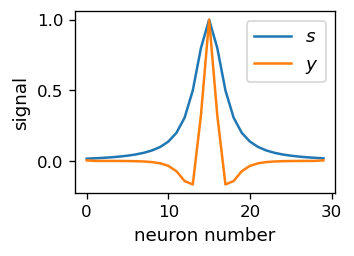

In [44]:
plt.figure(figsize=(2.8,2),dpi=120)

plt.plot(s)
plt.plot(y)
plt.legend(('$s$','$y$'),fontsize=11)
plt.xlabel('neuron number',fontsize=11)
plt.ylabel('signal',fontsize=11);    

Pyramidal neurons


```{admonition} Exercises
:class: warning

Construct a Kohonen mapping form a 2D shape (square, cicle, 2 disjoint squares) on a 2D grid of neurons.
```